In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 49

In [4]:
import utils

data_dict = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['network', 'fmin', 'fmax', 'length', 'sweep', 'port_pairs'])

## Pre-process the data

In [6]:
data_net = data_dict['network']
data_freqs = data_dict['network'].frequency

In [7]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 9999
Spacing: 6.0012e+06
Start: 0.0000e+00
Stop: 6.0000e+10


In [8]:
f_start = data_freqs.start
f_step = data_freqs.step
good_spacing = (f_start / f_step).is_integer()
print("Can extrapolate without aliasing: ", good_spacing)

spacing = data_dict["sweep"]
print("SPACING: ", spacing)

good_chip = good_spacing and (spacing == "LINEAR")
print("GOOD SPACING!!!" if good_chip else "BAD SPACING???")

Can extrapolate without aliasing:  True
SPACING:  LINEAR
GOOD SPACING!!!


In [9]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['0.0000e+00', '6.0012e+06', '1.2002e+07', '1.8004e+07', '2.4005e+07']


In [10]:
data_net = data_net.extrapolate_to_dc()
data_freqs = data_net.frequency 

In [11]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 9999
Spacing: 6.0012e+06
Start: 0.0000e+00
Stop: 6.0000e+10


In [12]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['0.0000e+00', '6.0012e+06', '1.2002e+07', '1.8004e+07', '2.4005e+07']


## Make some variables we will need

In [13]:
N_FREQS = data_freqs.npoints
N_SPARAMS = int(data_net.nports * (data_net.nports + 1) / 2)

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  9999
N_SPARAMS:  78


In [14]:
out_matrix_re = data_net.s.real
out_matrix_im = data_net.s.imag
out_matrix = np.stack((out_matrix_re, out_matrix_im), axis=-1)

out_sparams = utils.matrix_to_sparams(out_matrix)

x = torch.from_numpy(out_sparams).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 156, 9999])


In [15]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 78, 9999])


## Grab Some Measurements

In [16]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
M = 0.05

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  9999
Number of Measurements:  499
Undersampling Ratio:  0.0499049904990499


In [17]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = data_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.npoints)

y shape:  torch.Size([1, 156, 499])
y_freqs shape:  499


In [18]:
y_mag = utils.sparams_to_mag(y)

print("y_mag shape: ", y_mag.shape)

y_mag shape:  torch.Size([1, 78, 499])


In [19]:
z = torch.clone(x)
z[:, :, missing_inds] = 0

print("z shape: ", z.shape)

z shape:  torch.Size([1, 156, 9999])


## Plot data and measurements

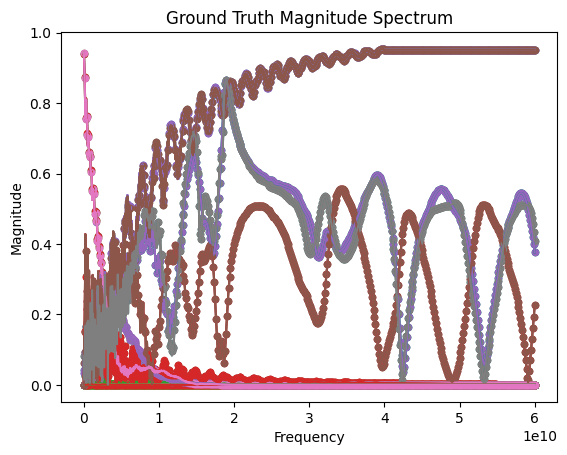

In [20]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(data_freqs.f, x_mag[0, i].cpu(), label=str(i))
    plt.scatter(y_freqs.f, y_mag[0, i].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

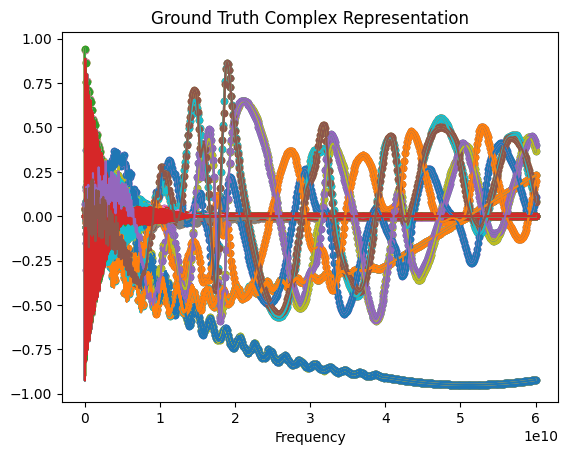

In [21]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(data_freqs.f, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(data_freqs.f, x[0,2*i+1].cpu(), label=str(i)+" Im")
    plt.scatter(y_freqs.f, y[0,2*i].cpu(), s=20)
    plt.scatter(y_freqs.f, y[0,2*i+1].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

# 2. Network Setup

## Define network parameters

In [22]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 5 

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NUM_LAYERS = 3
BASE_NGF = 256

NC = y.shape[1]

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [23]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  156
NUM_LAYERS:  3
BASE NGF:  256
NC:  156
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False
K:  1
NEW_CAUSAL True


## Init and check dimensions

In [24]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [25]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 156, 9999])


In [26]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  4208280


# Define Running Functions and Stuff

In [27]:
LR = 2e-4 
NUM_ITER = 20000 

REG_HYPERPARAM = 1.0
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 3
REG_NORM = 1

# REG_HYPERPARAM = 1e-2
# REG_TYPE = "wd"
# REG_TARGET = None #this is only sety if we are using centered_wd regularisation
# REG_ORDER = None
# REG_NORM = None

# REG_HYPERPARAM = 1e-5
# REG_TYPE = "centered_wd"
# REG_TARGET = None #this is only sety if we are using centered_wd regularisation
# REG_ORDER = None
# REG_NORM = None

REDUCTION = "mean"

In [28]:
START_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

# START_NOISE_LEVEL = None
# NOISE_DECAY_FACTOR = None

Noise decay factor:  0.9996546718755381


In [29]:
# SGLD = False
# BURN_IN_ITER = 5000
# SAVE_OUTPUT_EVERY = 1

SGLD = True
BURN_IN_ITER = NUM_ITER - 5000
SAVE_OUTPUT_EVERY = 100

In [30]:
import Fitting

dip_args = {"y": y,
            "x": x,
            "z": z,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": kept_inds,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [31]:
dip_results = Fitting.run_dip(dip_args)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [32]:
print("Final MSE: %.2e" % dip_results.mse_list_gt[-1])
print("Final Mean MSE: %.2e" % dip_results.mse_list_mean_gt[-1])

Final MSE: 2.16e-04
Final Mean MSE: 2.06e-04


3904


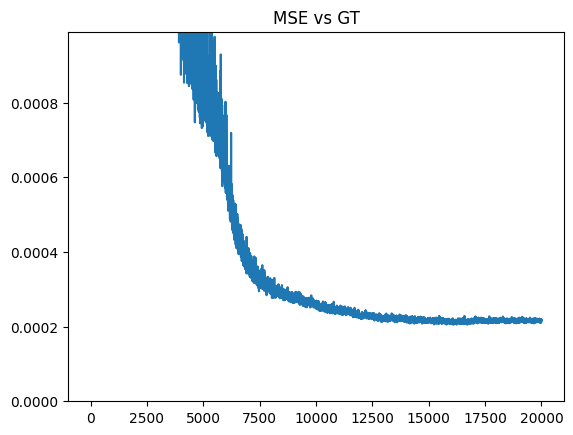

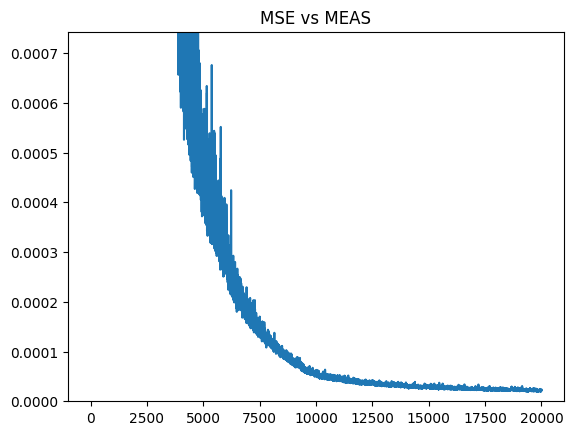

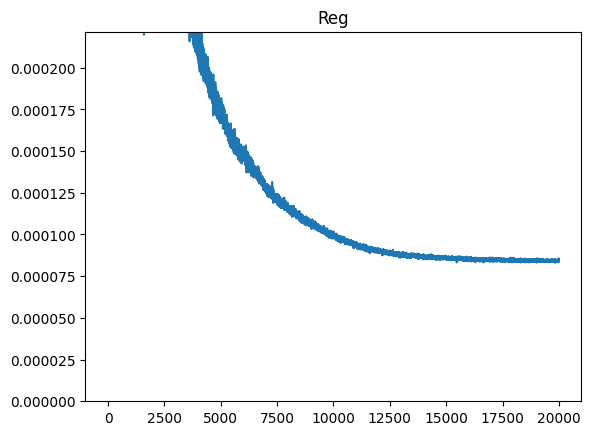

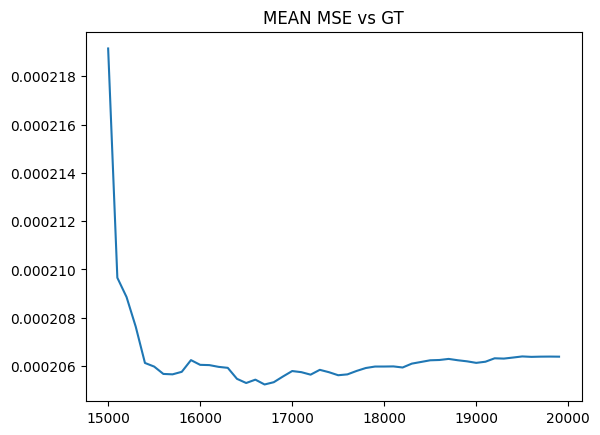

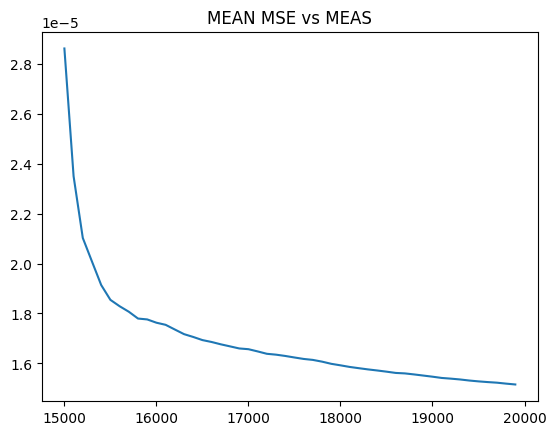

In [33]:
MAX_IDX = np.argwhere(np.array(dip_results.mse_list_gt) < 1e-3)[0][0]
print(MAX_IDX)

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.show()

In [34]:
out_mag_list = [utils.sparams_to_mag(i) for i in dip_results.out_list]

mean_out_mag = torch.mean(torch.cat(out_mag_list), dim=0, keepdim=True)
std_out_mag = torch.std(torch.cat(out_mag_list), dim=0, keepdim=True)

In [35]:
last_out = dip_results.out_list[-1]

last_out_mag = utils.sparams_to_mag(last_out)

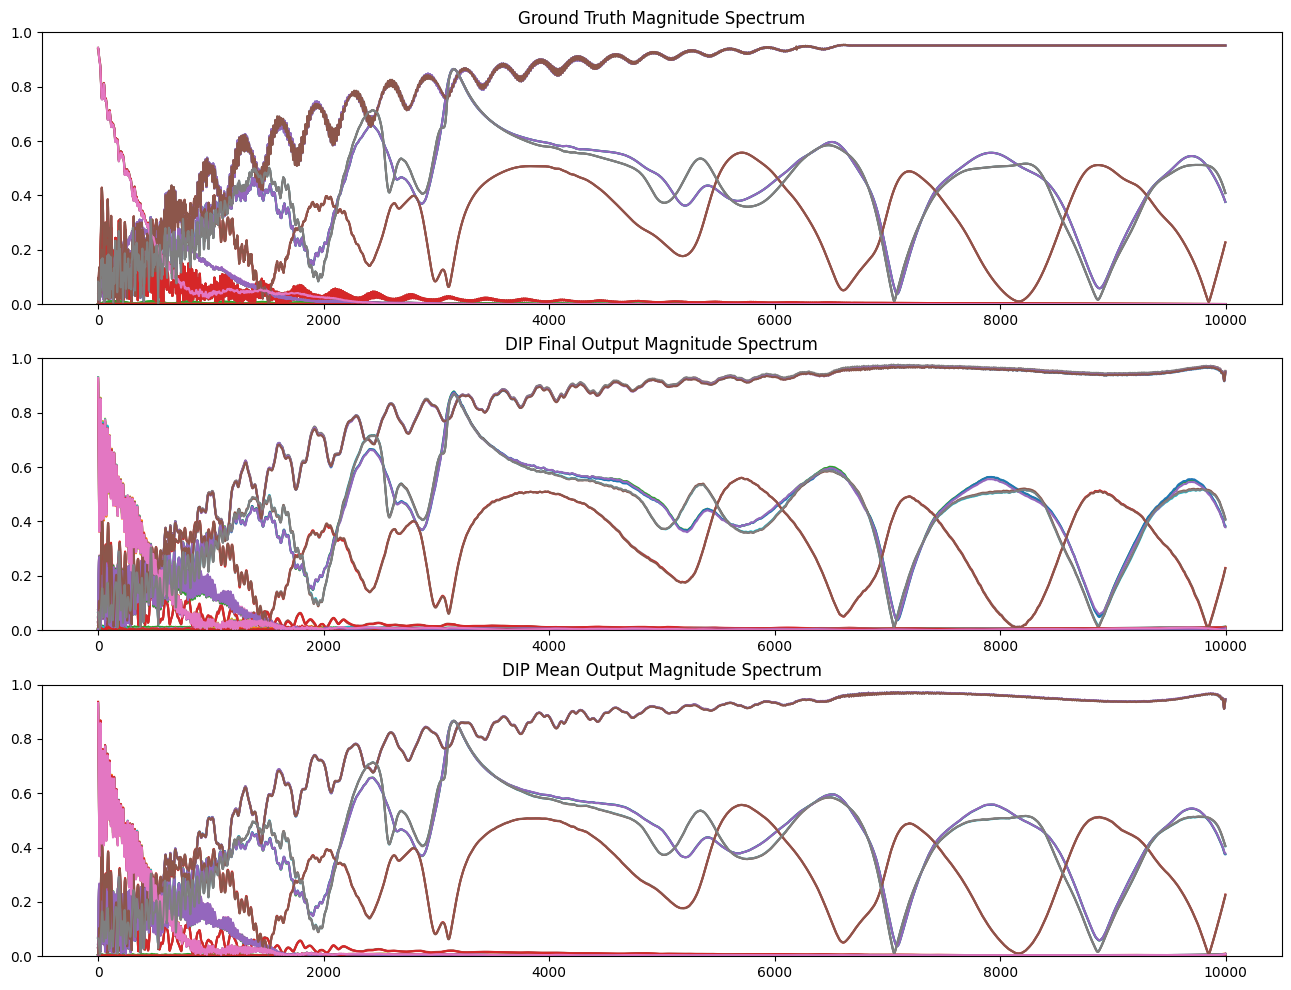

In [36]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[1].plot(last_out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[2].plot(mean_out_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

Text(0.5, 1.0, 'Mean')

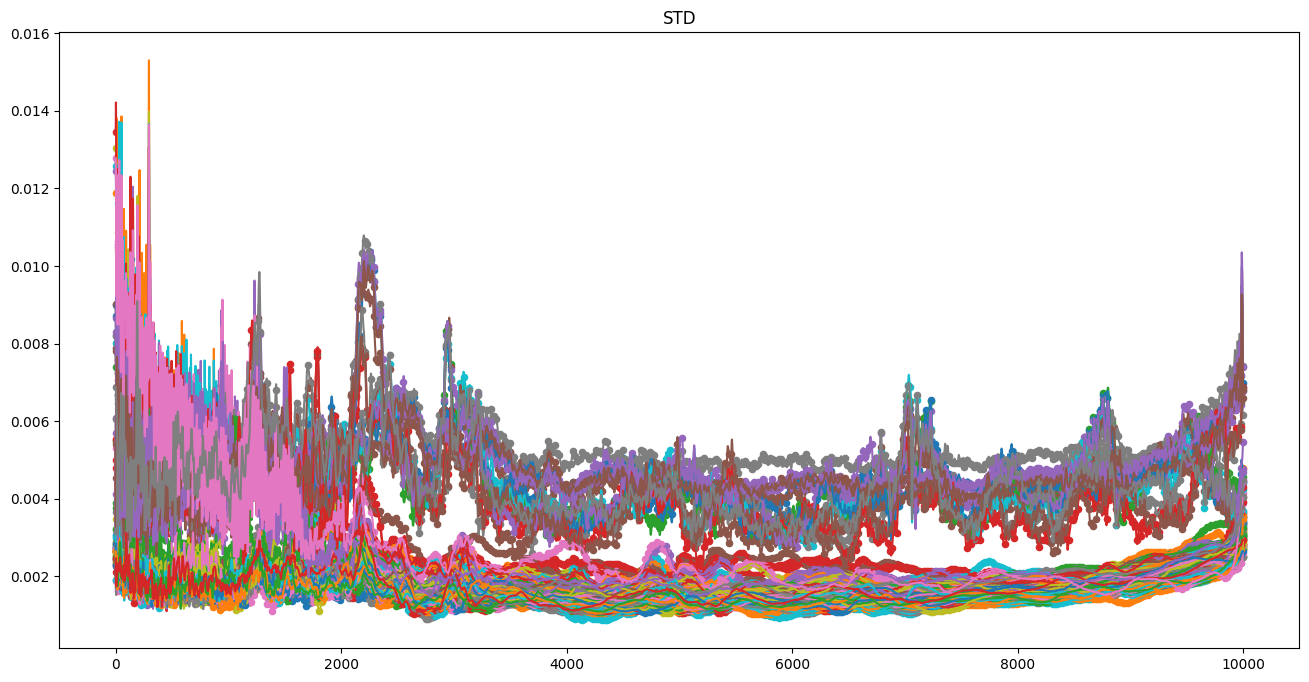

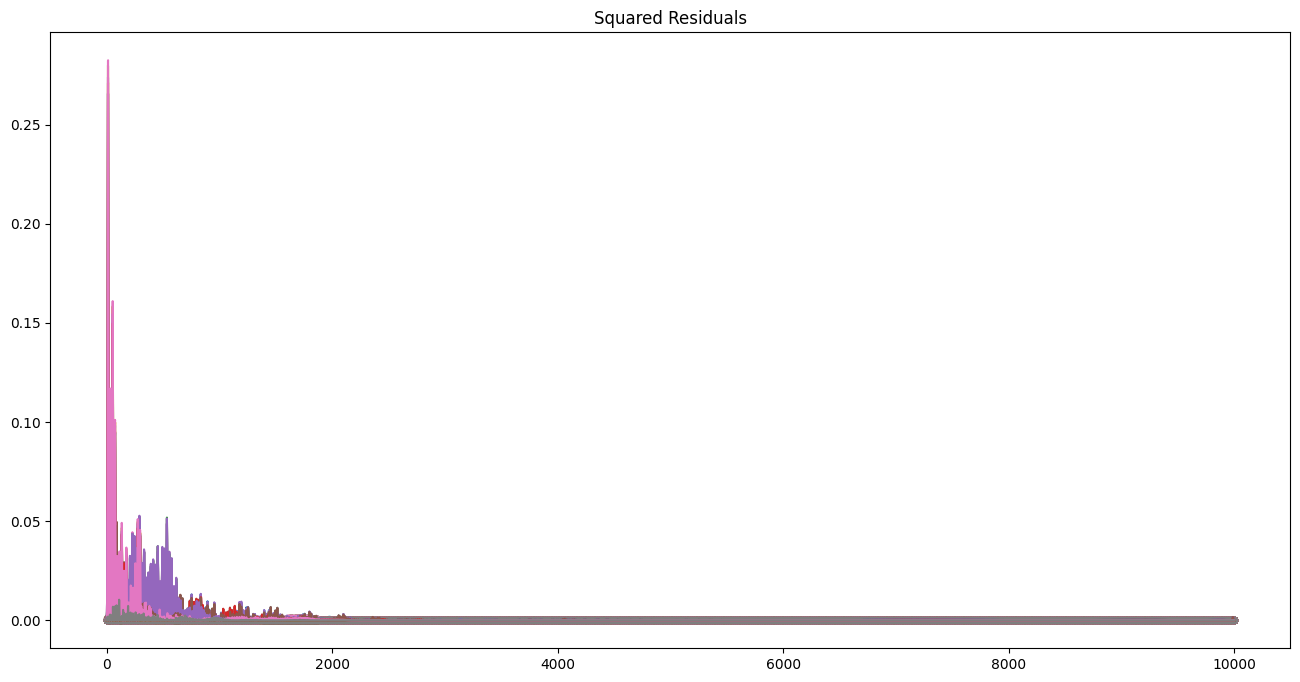

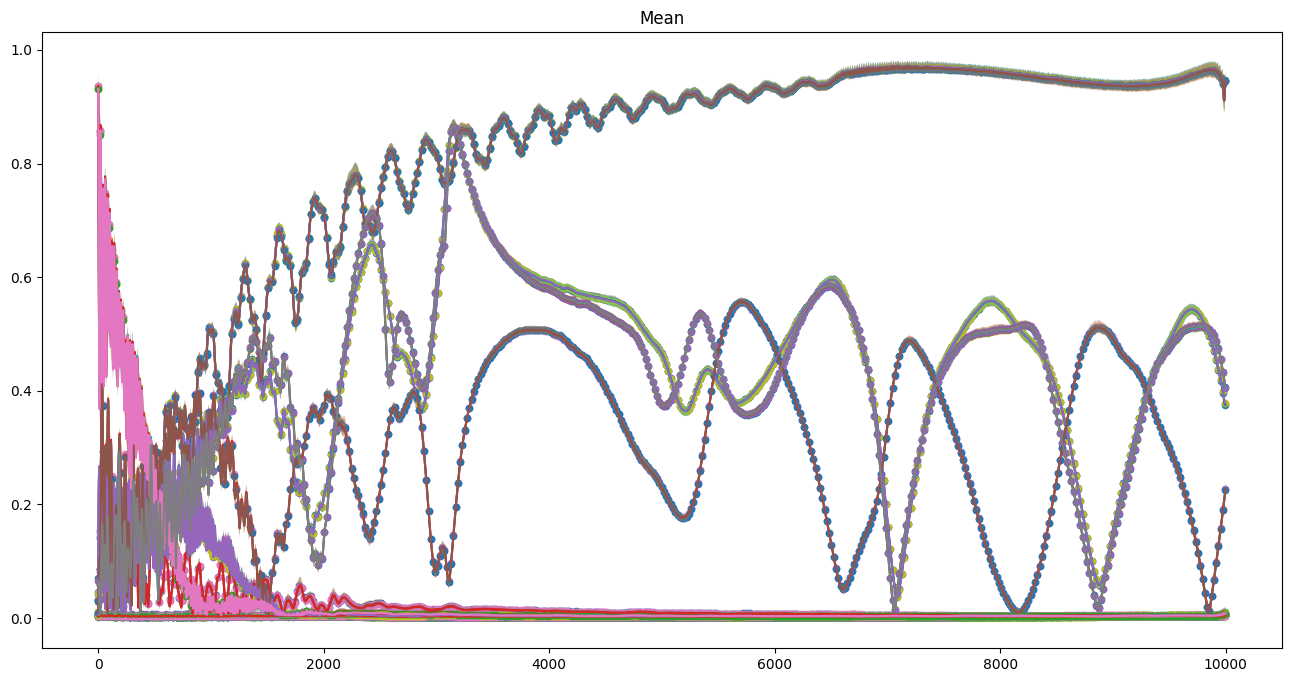

In [37]:
under_line = mean_out_mag - 1.96*std_out_mag
over_line = mean_out_mag + 1.96*std_out_mag

resid_mag = torch.square(x_mag - mean_out_mag)

plt.figure(figsize=(16,8))
for i in range(std_out_mag.shape[1]):
    plt.plot(std_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, std_out_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,8))
for i in range(resid_mag.shape[1]):
    plt.plot(resid_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, resid_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,8))
for i in range(mean_out_mag.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, mean_out_mag[0,i][kept_inds].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")